In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dst-car-price-prediction-part2/sample_submission.csv
/kaggle/input/sf-dst-car-price-prediction-part2/train.csv
/kaggle/input/sf-dst-car-price-prediction-part2/test.csv
/kaggle/input/sf-dst-car-price-prediction-part2/img/img/1099952182.jpg
/kaggle/input/sf-dst-car-price-prediction-part2/img/img/1099760426.jpg
/kaggle/input/sf-dst-car-price-prediction-part2/img/img/1098602592.jpg
/kaggle/input/sf-dst-car-price-prediction-part2/img/img/1099459442.jpg
/kaggle/input/sf-dst-car-price-prediction-part2/img/img/1099915820.jpg
/kaggle/input/sf-dst-car-price-prediction-part2/img/img/1100250106.jpg
/kaggle/input/sf-dst-car-price-prediction-part2/img/img/1097983236.jpg
/kaggle/input/sf-dst-car-price-prediction-part2/img/img/1097690708.jpg
/kaggle/input/sf-dst-car-price-prediction-part2/img/img/1100181932.jpg
/kaggle/input/sf-dst-car-price-prediction-part2/img/img/1088478624.jpg
/kaggle/input/sf-dst-car-price-prediction-part2/img/img/1094300816.jpg
/kaggle/input/sf-dst-car-price-pre

In [2]:
!pip install -q tensorflow==2.3

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
beatrix-jupyterlab 3.1.6 requires google-cloud-bigquery-storage, which is not installed.
thinc 8.0.15 requires typing-extensions<4.0.0.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions 4.1.1 which is incompatible.
tfx-bsl 1.5.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.15.0 which is incompatible.
tfx-bsl 1.5.0 requires pyarrow<6,>=1, but you have pyarrow 6.0.1 which is incompatible.
tfx-bsl 1.5.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,<3,>=1.15.2, but you have tensorflow 2.3.0 which is incompatible.
tensorflow-transform 1.5.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.15.0 whic

In [3]:
#аугментации изображений
!pip install albumentations -q

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

2022-04-12 13:38:04.988763: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:
2022-04-12 13:38:04.988823: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
Numpy        : 1.20.3
Tensorflow   : 2.3.0


In [6]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [7]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [8]:
!pip freeze > requirements.txt

In [9]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [11]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

# Model 1: Создадим "наивную" модель

In [12]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [13]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: nan%


# EDA

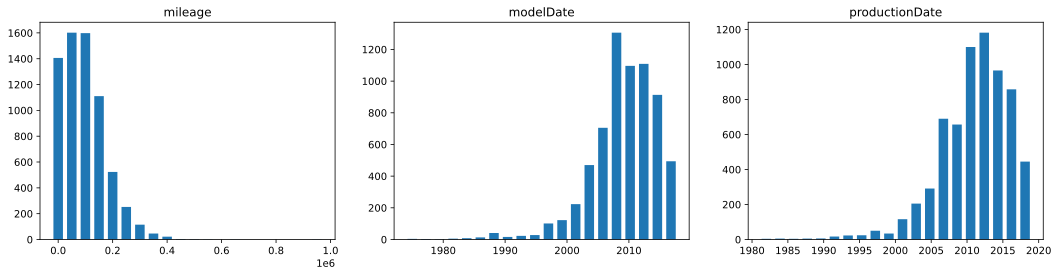

In [14]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

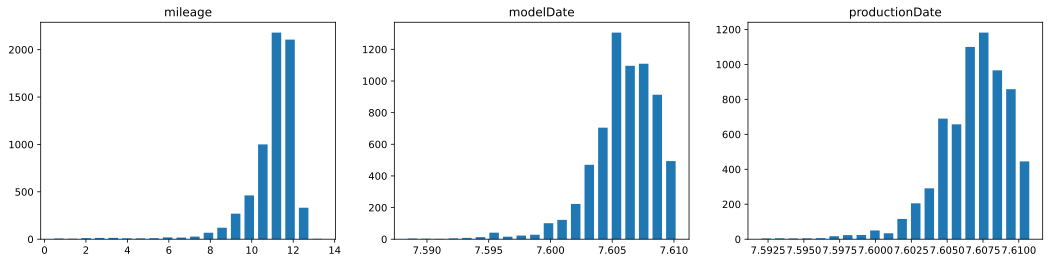

In [15]:
visualize_distributions({
    'mileage': np.log(train['mileage']+1).dropna(),
    'modelDate': np.log(train['modelDate']+1).dropna(),
    'productionDate': np.log(train['productionDate']+1).dropna()
})

In [16]:
train[['engineDisplacement', 'enginePower','Владение','Владельцы','name']]

,engineDisplacement,enginePower,Владение,Владельцы,name
0,3.0 LTR,272 N12,NaN,3 или более,530xi 3.0 AT (272 л.с.) 4WD
1,2.8 LTR,204 N12,8 лет и 6 месяцев,2 владельца,2.8 CVT (204 л.с.)
2,3.5 LTR,306 N12,NaN,3 или более,350 3.5 AT (306 л.с.) 4WD
3,2.0 LTR,180 N12,4 года и 9 месяцев,3 или более,2.0 CVT (180 л.с.)
4,1.8 LTR,160 N12,2 года и 9 месяцев,3 или более,1.8 CVT (160 л.с.)
...,...,...,...,...,...
6677,2.0 LTR,150 N12,NaN,3 или более,320i 2.0 AT (150 л.с.)
6678,2.0 LTR,190 N12,2 года и 2 месяца,3 или более,520d 2.0d AT (190 л.с.)
6679,2.0 LTR,143 N12,2 года и 2 месяца,3 или более,318i 2.0 AT (143 л.с.)
6680,3.0 LTR,310 N12,NaN,3 или более,Long 3.0 AT (310 л.с.) 4WD


In [17]:
import nltk
nltk.download('punkt')
from nltk import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
english_stopwords = stopwords.words("english")

import string
print(string.punctuation)

spec_chars = string.punctuation + '«»—…’‘”“©'
print(spec_chars)

# Зададим функцию для удаления спец символов
def remove_chars_from_text(text, chars):
    return "".join([ch for ch in text if ch not in chars])

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~«»—…’‘”“©


In [18]:
english_stopwords_ = english_stopwords + ['лс','квт']

In [19]:
# Зададим функцию для токенизации
def text_tokenizer(text):
    Text_ = text.strip()

    Text_ = Text_.lower()

    # Удалим все спец символы
    Text_ = remove_chars_from_text(Text_, spec_chars)

    # Удалим все цифры
    Text_ = remove_chars_from_text(Text_, string.digits)

    Text_ = Text_.replace('\n',' ').replace('\t',' ')

    # Токенизируем текст
    tokens = word_tokenize(Text_)

    # Список токенов преобразовываем к классу Text
    token_text = nltk.Text(tokens)

    # Удаляем стоп-слова
    filtered_token_text = [w for w in token_text if not w in english_stopwords]
    
    return filtered_token_text

In [20]:
train['vehicleConfiguration'].apply(lambda x: text_tokenizer(x))

0           [sedan, automatic]
1            [sedan, variator]
2           [sedan, automatic]
3            [sedan, variator]
4         [liftback, variator]
                 ...          
6677        [sedan, automatic]
6678        [sedan, automatic]
6679        [sedan, automatic]
6680        [sedan, automatic]
6681    [limousine, automatic]
Name: vehicleConfiguration, Length: 6682, dtype: object

# PreProc Tabular Data

In [21]:
#используем все текстовые признаки как категориальные без предобработки
categorical_features = ['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 'fuelType', 'model_info',
  'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'Руль']

#используем все числовые признаки
numerical_features = ['mileage', 'modelDate', 'productionDate', 'how_old', 'mile_per_year',
                     'engineDisplacement_N','enginePower_N']

In [22]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [23]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки и убираем признак Владение, так как в нем 
    # слишком много пропусков
    df_output.drop(['description','sell_id','Владение'], axis = 1, inplace=True)
    
    
    # ################### Feature Engineering ####################################################

    # Разберемся на сколько старый наш старина
    df_output['how_old'] = df_output['productionDate'].apply(lambda x: pd.Timestamp.today().year - x)
    
    # А также узнаем на сколько сильно его шатали
    df_output['mile_per_year'] = df_output['mileage'] / df_output['how_old']
    
    # ################### Numerical Features ############################################################## 
    
    # Сделаем числовой признка из engineDisplacement
    df_output['engineDisplacement_N'] = df_output['engineDisplacement'].apply(lambda x:
                                                                           x[:x.find(' LTR')])
    
    df_output['engineDisplacement_N'] = df_output['engineDisplacement_N'].apply(lambda x: float(x) if len(x)<4 else 0)
    
    # Сделаем числовой признка из enginePower
    df_output['enginePower_N'] = df_output['enginePower'].apply(lambda x: int(x[:x.find(' N12')]))
    
    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = np.log(df_output[column] + 1)
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
        
    # вытаскиеваем все ценное из name
    df_output['name'] = df_output['name'].apply(lambda x: text_tokenizer(x))
    
    name_dum = df_output['name'].apply(lambda x: str(x).replace('[','').replace(']','')).str.get_dummies(sep=', ').reset_index(drop=True)
    
    # вытаскиеваем все ценное из vehicleConfiguration
    df_output['vehicleConfiguration'] = df_output['vehicleConfiguration'].apply(lambda x: text_tokenizer(x))
    
    VeCo_dum = df_output['vehicleConfiguration'].apply(lambda x: str(x).replace('[','').replace(']','')).str.get_dummies(sep=', ').reset_index(drop=True)
    
    # соединим новые думисы с основной таблицой
    df_output = pd.concat([df_output, name_dum], axis=1)
    df_output = pd.concat([df_output, VeCo_dum], axis=1)
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)


    
    return df_output

In [24]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

,mileage,modelDate,name,productionDate,vehicleConfiguration,sample,price,how_old,mile_per_year,engineDisplacement_N,...,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1
7399,0.829686,0.896948,"[xdrive, лс, wd]",0.869500,"[allroaddoors, automatic]",1,1590000.0,0.375084,0.859246,0.541682,...,1,0,0,0,1,0,0,1,1,0
4273,0.763680,0.876307,"[e, hyb, лс, wd]",0.895626,"[allroaddoors, automatic]",1,3100000.0,0.324019,0.794247,0.541682,...,1,0,0,0,1,0,0,1,1,0
3362,0.778972,0.876307,"[amg, long, лс, wd]",0.869500,"[sedan, automatic]",1,3750000.0,0.375084,0.798494,0.922912,...,0,0,1,0,1,0,0,1,1,0
2794,0.841535,0.834995,"[amt, лс, wd]",0.764868,"[sedan, robot]",1,1990000.0,0.530140,0.832178,0.683527,...,0,0,1,0,1,0,0,1,1,0
5378,0.854919,0.876307,"[xdrive, лс, wd]",0.869500,"[sedan, automatic]",1,1285000.0,0.375084,0.889474,0.541682,...,0,0,1,0,1,0,0,1,1,0
5902,0.797132,0.855656,"[лс, wd]",0.817210,"[wagondoors, automatic]",1,3399999.0,0.460417,0.797306,0.793550,...,1,0,0,0,1,0,0,1,1,0
1454,0.775812,0.855656,"[li, xdrive, лс, wd]",0.869500,"[sedan, automatic]",0,0.0,0.375084,0.794709,0.683527,...,0,1,0,0,1,0,0,1,1,0
2476,0.866520,0.752246,[лс],0.686256,"[sedan, automatic]",1,700000.0,0.615473,0.840093,0.617688,...,0,0,1,1,0,1,0,0,1,0
743,0.838424,0.752246,[лс],0.738677,"[hatchbackdoors, automatic]",0,0.0,0.560749,0.820509,0.471125,...,0,0,1,0,1,1,0,0,1,0
1168,0.746676,0.855656,"[amg, лс, wd]",0.843362,"[allroaddoors, automatic]",0,0.0,0.420126,0.747619,0.922912,...,0,0,1,0,1,0,0,1,1,0


In [25]:
# И чуть не забыли - надо кое-что дропнуть
df_preproc.drop(['name','vehicleConfiguration'], axis = 1, inplace=True)

In [26]:
df_preproc.sample(4)

,mileage,modelDate,productionDate,sample,price,how_old,mile_per_year,engineDisplacement_N,enginePower_N,'activehybrid',...,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1
3640,0.885647,0.772948,0.686256,1,630000.0,0.615473,0.863007,0.541682,0.437745,0,...,1,0,0,0,1,0,0,1,1,0
6421,0.859193,0.793641,0.791045,1,680000.0,0.496865,0.862032,0.541682,0.309008,0,...,0,1,0,0,1,1,0,0,1,0
7645,0.820622,0.752246,0.712473,1,599000.0,0.589089,0.791876,0.507665,0.337870,0,...,0,1,0,0,1,0,1,0,1,0
7222,0.744529,0.917579,0.895626,1,2150000.0,0.324019,0.771307,0.541682,0.528676,0,...,0,1,0,0,1,0,0,1,1,0


In [27]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 470 entries, mileage to Руль_1
dtypes: float64(8), int64(79), uint8(383)
memory usage: 8.6 MB


# Split data

In [28]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [29]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 469 entries, mileage to Руль_1
dtypes: float64(8), int64(78), uint8(383)
memory usage: 1.7 MB


# Model 2: CatBoostRegressor

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [31]:
model = CatBoostRegressor(iterations = 5000,
                          #depth=10,
                          #learning_rate = 0.5,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.025058
0:	learn: 0.9842845	test: 1.0082857	best: 1.0082857 (0)	total: 57.4ms	remaining: 4m 46s
100:	learn: 0.2944630	test: 0.2930577	best: 0.2930577 (100)	total: 398ms	remaining: 19.3s
200:	learn: 0.2312867	test: 0.2289236	best: 0.2288573 (197)	total: 730ms	remaining: 17.4s
300:	learn: 0.1933900	test: 0.1925958	best: 0.1925958 (300)	total: 1.07s	remaining: 16.7s
400:	learn: 0.1767138	test: 0.1770279	best: 0.1770279 (400)	total: 1.4s	remaining: 16.1s
500:	learn: 0.1658825	test: 0.1667815	best: 0.1667815 (500)	total: 1.74s	remaining: 15.6s
600:	learn: 0.1569772	test: 0.1579688	best: 0.1579688 (600)	total: 2.09s	remaining: 15.3s
700:	learn: 0.1506204	test: 0.1526757	best: 0.1526656 (699)	total: 2.45s	remaining: 15s
800:	learn: 0.1457133	test: 0.1491043	best: 0.1490921 (798)	total: 2.78s	remaining: 14.6s
900:	learn: 0.1414593	test: 0.1459925	best: 0.1459925 (900)	total: 3.14s	remaining: 14.3s
1000:	learn: 0.1373900	test: 0.1434411	best: 0.1434411 (1000)	total: 3.47s	

In [32]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 12.49%


# Submission

In [33]:
sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

# Model 3: Tabular NN

In [34]:
X_train.head(5)

,mileage,modelDate,productionDate,how_old,mile_per_year,engineDisplacement_N,enginePower_N,'activehybrid','ah','allterrain',...,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1
7320,0.855429,0.772948,0.764868,0.530140,0.848822,0.959452,0.886702,0,0,0,...,1,0,0,0,1,1,0,0,1,0
8037,0.705392,0.938200,0.947839,0.195347,0.761437,0.541682,0.528676,0,0,0,...,1,0,0,0,1,0,0,1,1,0
4681,0.846775,0.690076,0.633784,0.663338,0.804250,0.695702,0.546610,0,0,0,...,0,0,1,0,1,0,0,1,1,0
6014,0.915514,0.731533,0.660027,0.640154,0.892487,0.507665,0.400411,0,0,0,...,0,0,1,0,1,1,0,0,1,0
3649,0.842142,0.834995,0.817210,0.460417,0.851225,0.683527,0.638525,0,0,0,...,1,0,0,0,1,0,0,1,1,0


# Simple Dense NN

In [35]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

2022-04-12 13:38:52.756858: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:
2022-04-12 13:38:52.756911: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-12 13:38:52.756941: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (2c0971dd813e): /proc/driver/nvidia/version does not exist
2022-04-12 13:38:52.757251: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               240128    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 371,713
Trainable params: 371,713
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [38]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

# Fit

In [39]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

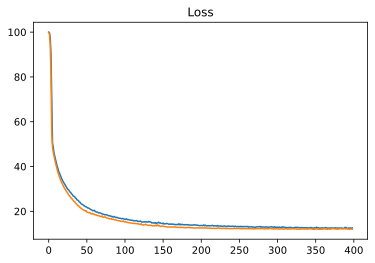

In [40]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [41]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [42]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 12.03%


In [43]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

# Model 4: NLP + Multiple Inputs

In [44]:
data.description

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

In [45]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [46]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

# Tokenizer

In [47]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 1.81 s, sys: 4.49 ms, total: 1.82 s
Wall time: 1.82 s


In [48]:
tokenize.word_index

{'•': 1,
 'в': 2,
 'и': 3,
 'с': 4,
 'на': 5,
 'не': 6,
 'по': 7,
 'система': 8,
 'автомобиль': 9,
 'все': 10,
 'для': 11,
 'автомобиля': 12,
 'от': 13,
 'до': 14,
 'при': 15,
 'у': 16,
 'пробегом': 17,
 '2': 18,
 'состоянии': 19,
 'без': 20,
 'авто': 21,
 'салон': 22,
 'пакет': 23,
 'за': 24,
 'машина': 25,
 'автомобилей': 26,
 'сидений': 27,
 'птс': 28,
 'безопасности': 29,
 'то': 30,
 'bmw': 31,
 'из': 32,
 'более': 33,
 '000': 34,
 'автомобили': 35,
 'водителя': 36,
 'комплектация': 37,
 'есть': 38,
 '1': 39,
 'года': 40,
 'комплект': 41,
 'сиденья': 42,
 'только': 43,
 'дилера': 44,
 'салона': 45,
 'пробег': 46,
 'контроль': 47,
 'фары': 48,
 '6': 49,
 'диски': 50,
 'кредит': 51,
 'лет': 52,
 'передние': 53,
 '3': 54,
 'руля': 55,
 'датчик': 56,
 'пассажира': 57,
 'км': 58,
 'оригинал': 59,
 'подушки': 60,
 'а': 61,
 'мы': 62,
 '9': 63,
 'подогрев': 64,
 'заднего': 65,
 'состояние': 66,
 'вас': 67,
 '5': 68,
 'обслуживание': 69,
 'зеркал': 70,
 '–': 71,
 'торг': 72,
 'дтп': 73,
 '

In [49]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 1.64 s, sys: 0 ns, total: 1.64 s
Wall time: 1.65 s


In [50]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

.

• Автомобиль проверен по 110 пунктам
• Автокредит по специальной ставке от 13,7%

Ауди Центр Север, официальный дилер Audi, входящий в группу компаний РОЛЬФ и являющийся одним из крупнейших дилеров в Европе, предлагает Вам ряд услуг по покупке и продаже автомобилей с пробегом.

На протяжении многих лет наш дилерский центр является лидером по продаже автомобилей с пробегом среди всех дилеров Audi в России и предоставляет клиентам самый большой выбор автомобилей с пробегом Audi и других марок.
Каждый автомобиль проходит тщательную диагностику и подготовку, и гарантировано находится в отличном состоянии.
Чтобы убедиться в правильном выборе, у Вас есть возможность пройти тест-драйв ― ознакомительную поездку на интересующем автомобиле.
Вы сможете ознакомиться с автомобилем не выходя из дома – наш менеджер проведет online презентацию и в видеозвонке покажет выбранный автомобиль.
Также Ауди Центр Север представляет уникальное предложение по кредитованию автомобилей с пробегом на индивидуал

# RNN NLP

In [51]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

# MLP

In [ ]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

# Multiple Inputs NN

In [ ]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [ ]:
model.summary()

# Fit

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [ ]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [ ]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [ ]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

In [ ]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

# Model 5: Добавляем картинки

# Data

In [ ]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [ ]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

# albumentations

In [ ]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:
def make_augmentations(images):
    print('применение аугментаций', end = '')
    augmented_images = np.empty(images.shape)
    for i in range(images.shape[0]):
        if i % 200 == 0:
            print('.', end = '')
        augment_dict = augmentation(image = images[i])
        augmented_image = augment_dict['image']
        augmented_images[i] = augmented_image
    print('')
    return augmented_images

# tf.data.Dataset

In [ ]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [ ]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

# Строим сверточную сеть для анализа изображений без "головы"

In [ ]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

In [ ]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [ ]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [ ]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [ ]:
history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [ ]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [ ]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

In [ ]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)

# Blend

In [ ]:
blend_predict = (test_predict_catboost + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

In [ ]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

# Model Bonus: проброс признака

In [ ]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [ ]:
# FEATURE Input
# Iput
productiondate = L.Input(shape=[1], name="productiondate")
# Embeddings layers
emb_productiondate = L.Embedding(len(X.productionDate.unique().tolist())+1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)

In [ ]:
combinedInput = L.concatenate([model_mlp.output, f_productiondate,])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [ ]:
model.summary()

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
history = model.fit([X_train, X_train.productionDate.values], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test, X_test.productionDate.values], y_test),
                    callbacks=callbacks_list
                   )

In [ ]:
model.load_weights('../working/best_model.hdf5')
test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")